In [2]:
import os
import sys
import random
import cv2
import math
import re
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from sklearn.decomposition import PCA

from datetime import datetime
from tqdm import tqdm
from PIL import Image

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import dataprocess
import estimation
import MyModel
import visualize
import loss
import spectral

# torch.cuda.empty_cache()

# 1.全局设置Configurations
- 导入函数库
- 定义一些全局公用的参数，如裁剪图像的大小

In [3]:
class Config():
    TrainImageRoot = r'/home/hsilab/Data/working_syj/datasets/total/train'
    TestImageRoot = r'/home/hsilab/Data/working_syj/datasets/total/test'
    PositiveClass = "jinyinhua1"

    IMG_HIGHT = 100
    IMG_WIDTH = 100

    SPLIT_SIGN = '/'

    # 打印所有的全局参数
    def display(self):
        print("\nConfigurations:")
        for a in dir(self):
            if not a.startswith("__") and not callable(getattr(self, a)):
                print("{:30} {}".format(a, getattr(self, a)))
        print("\n")

config = Config()
config.display()



Configurations:
IMG_HIGHT                      100
IMG_WIDTH                      100
PositiveClass                  jinyinhua1
SPLIT_SIGN                     /
TestImageRoot                  /home/hsilab/Data/working_syj/datasets/total/test
TrainImageRoot                 /home/hsilab/Data/working_syj/datasets/total/train




# 2.定义Dataset
- __init__(self,*): 定义相关参数，图像预处理
- __len__(self): 用于获取Dataset的长度
- __getitem__(self, idx): 在list索引时返回一份预处理过的数据

在getitem中
1. 读取原始图像
2. 对原始图像引入块状噪声，因此需要写随机引入噪声的函数，高斯噪声？或者直接裁剪，添加随机颜色随机大小随机位置的色块 \
定义随机获取一个区域的函数 ： 图像大小，噪声块大小范围 输出 一个随机区域的mask，用于之后添加噪声和构建目标输出图像 \
思考一下:
- 怎么定义噪声，
- 定义什么形状的噪声，
- 定义几块噪声，
- 定义什么类型的噪声,
- 将噪声与原图像相加还是相乘 \
定义随机噪声函数 输入 ：原始图像 图像大小 噪声块大小范围  输出： 添加噪声后的图像
3. 构建目标输出图像 \
定义输出图像函数 输入 ：原始图像 图像大小 噪声块 输出：添加噪声后的图片

In [4]:
class TrainDataset(Dataset):
    # 输入参数为待分割图像的地址元组，GroundTruth的地址元组，以及两者的归一化函数
    def __init__(self, DatPath, HdrPath,label,ImageWidth, ImageHeight):
        
        self.DatPath = DatPath
        self.HdrPath = HdrPath
        self.label = label
        self.ImageWidth = ImageWidth
        self.ImageHeight = ImageHeight

        self.ImageTransformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.CenterCrop(self.ImageWidth),
        ])
        # self.pca = pca

    def __len__(self):
        return len(self.DatPath)

    def __getitem__(self, idx):
        DatPath = self.DatPath[idx]
        HdrPath = self.HdrPath[idx]

        # 读取图像
        
        img = spectral.envi.open(HdrPath, DatPath)
        img = img.read_bands(range(img.shape[2])) #读取全部的光谱维度
        img = img/65536 # turn to 0~1 img
        x = img.shape[0] # save width and hight of img , for recover
        y = img.shape[1]
        z = img.shape[2]
        img = img.reshape((-1,z)) # reshape to fit pca transform
        pca = PCA(10) 
        img = pca.fit_transform(img) # 主成分分析
        img = img.reshape((x,y,img.shape[-1]))
        
        img = img.transpose([2,0,1])
        img = torch.FloatTensor(img)
        img = transforms.RandomCrop(self.ImageWidth)(img) # 将图像裁剪到一定的输入大小上，保证输入的一致性
        # img = transforms.CenterCrop(self.ImageWidth)(img) # 将图像裁剪到一定的输入大小上，保证输入的一致性
        img = img.unsqueeze(0)

        return img,torch.FloatTensor(self.label[idx])

    def get_class(self, idx) :
        return self.DatPath[idx].split(config.SPLIT_SIGN)[-2]

    def get_fakeimg(self, idx) :
        DatPath = self.DatPath[idx]
        HdrPath = self.HdrPath[idx]

        # 读取图像
        img = spectral.envi.open(HdrPath, DatPath)
        red = img.read_band(241) #读取红光谱维度
        green = img.read_band(151)
        blue = img.read_band(71)
        img = np.stack([red,green,blue],axis=2)
        # img = cv2.resize(img, (self.ImageWidth, self.ImageHeight))
        img = img/65536

        return img
        

## 2.1 创建Dataset和Dataloader



In [5]:
# 获取训练集图像
from tkinter import Label


TrainImageRoot = config.TrainImageRoot
TrainDatPath = []
TrainHdrPath = []
TrainLabel = []
for root, dirs, files in os.walk(TrainImageRoot):
    for file in files:
        if file.split('.')[-1] == 'hdr' :
            TrainHdrPath.append(os.path.join(root, file))
        elif file.split('.')[-1] == 'dat' :
            TrainDatPath.append(os.path.join(root, file))


TrainHdrPath.sort()
TrainDatPath.sort()

# 根据文件地址创建label
for i in TrainHdrPath : 
    if i.split(config.SPLIT_SIGN)[-2] == "danggui1" :
        TrainLabel.append(0)
    elif i.split(config.SPLIT_SIGN)[-2] == "danggui2" :
        TrainLabel.append(1)
    elif i.split(config.SPLIT_SIGN)[-2] == "danggui4" :
        TrainLabel.append(2)
    elif i.split(config.SPLIT_SIGN)[-2] == "gouqi1" :
        TrainLabel.append(3)
    elif i.split(config.SPLIT_SIGN)[-2] == "gouqi2" :
        TrainLabel.append(4)
    elif i.split(config.SPLIT_SIGN)[-2] == "gouqi4" :
        TrainLabel.append(5)
    elif i.split(config.SPLIT_SIGN)[-2] == "jinyinhua1" :
        TrainLabel.append(6)
    elif i.split(config.SPLIT_SIGN)[-2] == "jinyinhua2" :
        TrainLabel.append(7)
    elif i.split(config.SPLIT_SIGN)[-2] == "jinyinhua4" :
        TrainLabel.append(8)
TrainLabel = dataprocess.onehot(np.array(TrainLabel),9)

TestImageRoot = config.TestImageRoot
TestDatPath = []
TestHdrPath = []
TestLabel = []
for root, dirs, files in os.walk(TestImageRoot):
    for file in files:
        if file.split('.')[-1] == 'hdr' :
            TestHdrPath.append(os.path.join(root, file))
        elif file.split('.')[-1] == 'dat' :
            TestDatPath.append(os.path.join(root, file))


TestHdrPath.sort()
TestDatPath.sort()

# 根据文件地址创建label
for i in TestHdrPath : 
    if i.split(config.SPLIT_SIGN)[-2] == "danggui1" :
        TestLabel.append(0)
    elif i.split(config.SPLIT_SIGN)[-2] == "danggui2" :
        TestLabel.append(1)
    elif i.split(config.SPLIT_SIGN)[-2] == "danggui4" :
        TestLabel.append(2)
    elif i.split(config.SPLIT_SIGN)[-2] == "gouqi1" :
        TestLabel.append(3)
    elif i.split(config.SPLIT_SIGN)[-2] == "gouqi2" :
        TestLabel.append(4)
    elif i.split(config.SPLIT_SIGN)[-2] == "gouqi4" :
        TestLabel.append(5)
    elif i.split(config.SPLIT_SIGN)[-2] == "jinyinhua1" :
        TestLabel.append(6)
    elif i.split(config.SPLIT_SIGN)[-2] == "jinyinhua2" :
        TestLabel.append(7)
    elif i.split(config.SPLIT_SIGN)[-2] == "jinyinhua4" :
        TestLabel.append(8)
TestLabel = dataprocess.onehot(np.array(TestLabel),9)
print(TestLabel[0])


[1. 0. 0. 0. 0. 0. 0. 0. 0.]


## PCA

In [6]:

# # 根据图像数据进行PCA
# # 按顺序读取图像
# data = np.ones((0,603))
# for i in range(len(TrainHdrPath)) :
#     hdr,dat = TrainHdrPath[i],TrainDatPath[i]
# # for hdr,dat in (TrainHdrPath,TrainDatPath) :
#     img = spectral.envi.open(hdr, dat)
#     img = img.read_bands(range(img.shape[2])) #读取全部的光谱维度
#     img = img.reshape(-1,img.shape[2])
#     data = np.vstack([data,img])
#     print(data.shape)

# pca = PCA(100)
# pca.fit(data)

# # save pca
# torch.save(pca,"checkpoints/pca/pca100.pth")

# hdr,dat = TrainHdrPath[0],TrainDatPath[0]
# img = spectral.envi.open(hdr, dat)
# img = img.read_bands(range(img.shape[2])) #读取全部的光谱维度
# img = img.reshape(-1,img.shape[2])
# img = pca.transform(img)

# print(img.shape)

# del data # delate data to save space
# del pca 

In [7]:
# load pca
# pca = torch.load("checkpoints/pca3.pth")
# create dataset
# train_dataset = TrainDataset(TrainDatPath,TrainHdrPath,TrainLabel,pca,config.IMG_WIDTH, config.IMG_HIGHT)
# test_dataset = TrainDataset(TestDatPath,TestHdrPath,TestLabel,pca ,config.IMG_WIDTH, config.IMG_HIGHT)

# create dataset without pca
train_dataset = TrainDataset(TrainDatPath,TrainHdrPath,TrainLabel,config.IMG_WIDTH, config.IMG_HIGHT)
test_dataset = TrainDataset(TestDatPath,TestHdrPath,TestLabel,config.IMG_WIDTH, config.IMG_HIGHT)



# 利用DataLoader生成一个分batch获取数据的可迭代对象
train_dataloader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)

## 2.2展示一份数据
用于验证Dataset返回的一份数据

(180, 180, 3)


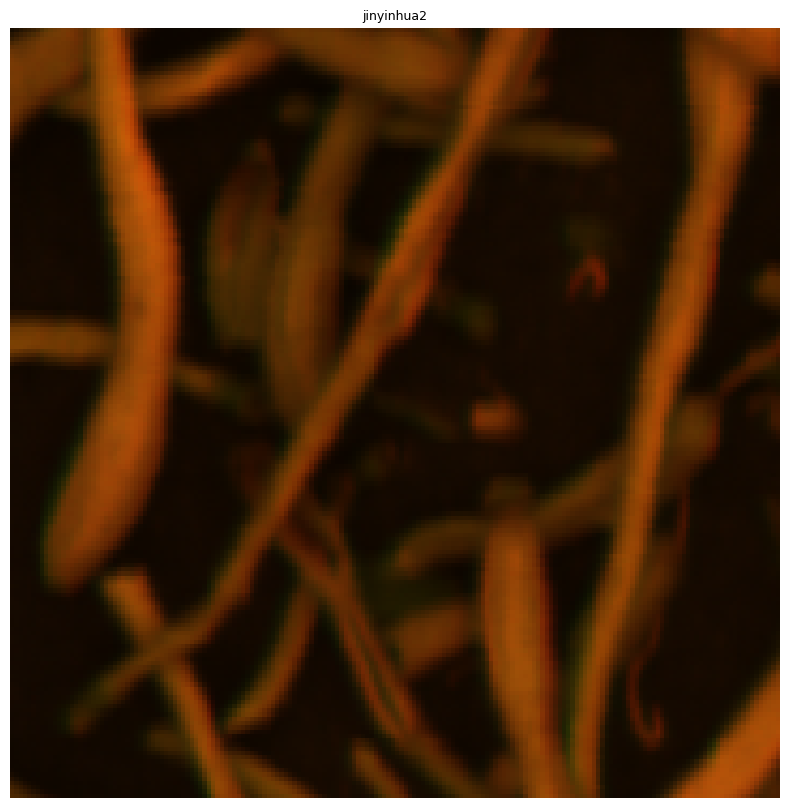

In [8]:
import random
import visualize

# Load and display random samples
image_id = random.randint(0,len(train_dataset)-1)
# image_name = train_dataset.get_class(image_id)
image_name = train_dataset.get_class(image_id)
img = train_dataset.get_fakeimg(image_id)

print(img.shape)

visualize.display_images([img],cols = 1,titles = [image_name],cmap = 'gray')


In [ ]:
img,label = train_dataset[image_id]
print(img.shape)
print(label)
print(len(train_dataset))

torch.Size([1, 10, 100, 100])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0.])
145


# 3.训练
训练初始化
- 创建模型实例，导入模型参数()
- 定义损失函数，实例化损失函数
- 定义优化器
- 定义训练过程指标记录变量(如何合理的)

训练开始
- 循环导入Dataloader数据
- 初始化优化器
- 模型前向传播
- 计算损失函数
- 损失函数反向传播
- 优化器进行优化
- 保存损失等相关训练参数

训练结束
- 保存训练模型，保存过程数据
- 绘制训练曲线

## 3.1 训练参数定义

start from model total_pca10_hybridsn_last start_epoch: 767 end epoch: 1766


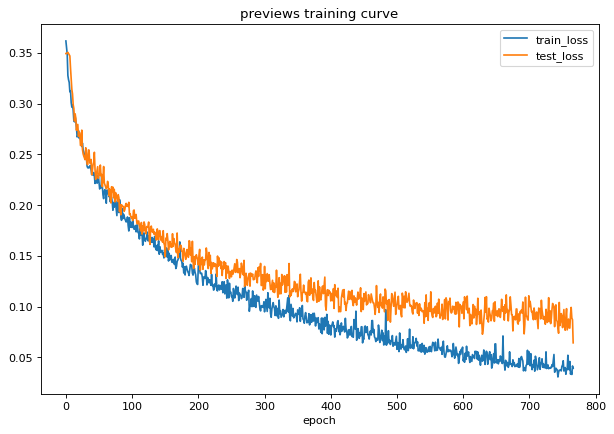

In [ ]:
# 决定初始化模型的版本号save_code
# None表示从零开始训练
# 其他数字表示从保存的版本号开始训练保存的版本号开始训练
# 从中导入之前的模型和训练曲线，以及开始的epoch
# 起始输入版本
# start_save_code = "danggui12_pca10_hybridsn_last"

start_save_code = "total_pca10_hybridsn_last"
# 目标输出版本

# 训练epoch数
epoch_num = 1000
# 每隔几个epoch更新一次保存序号
save_epoch = 10
# 创建模型实例
model = MyModel.multiclass_HybridSN(10,9)
if start_save_code == None :
    # 初始化训练曲线
    all_train_total_loss = []
    all_test_total_loss = []
    #初始epoch为0
    start_epoch = 0
    print("start from scratch, start epoch:",start_epoch, "end epoch:", start_epoch+epoch_num-1)
else :
    # 导入模型参数
    model.load_state_dict(torch.load(f"./checkpoints/{start_save_code}_model_param.pth"))
    # 导入训练曲线
    model_curve = torch.load(f"./checkpoints/{start_save_code}_model_curve.pth")
    all_train_total_loss = model_curve["all_train_total_loss"]
    all_test_total_loss = model_curve["all_test_total_loss"]
    # 初始epoch为训练曲线的长度
    start_epoch = len(all_train_total_loss)
    print(f"start from model {start_save_code} start_epoch:",start_epoch, "end epoch:", start_epoch+epoch_num-1)

    # 绘制训练过程曲线
    plt.figure(figsize=(9,6), dpi=80)
    # plt.subplot(121)
    plt.title('previews training curve')
    plt.plot(all_train_total_loss,label="train_loss")
    plt.plot(all_test_total_loss,label="test_loss")
    plt.legend(loc='upper right')
    plt.xlabel('epoch')

save_code = "total_pca10_hybridsn"
end_save_code = f"{save_code}_{start_epoch//save_epoch:02d}"


## 3.2 开始训练

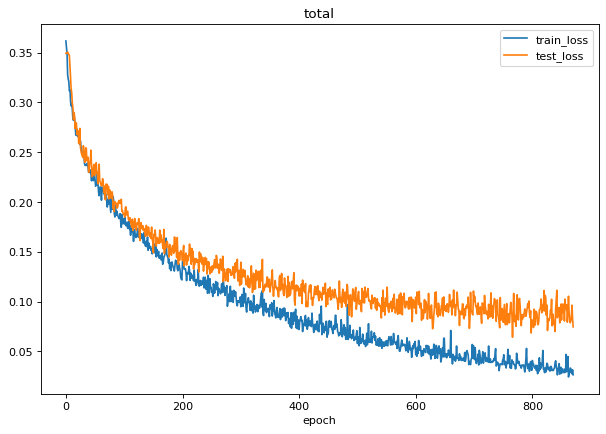

<---------------------------------------------------->
epoch: 870.000000
epoch train loss = 0.026466, epoch test loss = 0.074560, Time 00:02:57
epoch871 training


  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:32<01:37, 32.42s/it]

In [ ]:

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if sys.platform == "win32" :
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
elif sys.platform == "linux" :
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# if torch.cuda.is_available() :
#     torch.cuda.empty_cache() # 释放显存

model = model.to(device)
# 定义损失函数   这里只有两类，采用二分类常用的损失函数BCE
criterion = nn.BCELoss().to(device)
# criterion = nn.MSELoss().to(device)
# criterion2 = loss.SSIM().to(device)
# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# 记录开始时间
prev_time = datetime.now()
min_loss = float("inf") #初始化最小testloss
for epo in range(start_epoch, start_epoch + epoch_num):
    # 训练开始
    train_loss = 0 # 记录训练参数
    
    print(f"epoch{epo} training")
    model.train() # 模型切换为训练模式，模型参数可以反向传播和梯度下降
    # 导入Dataloader数据 
    
    for index, (img,label) in tqdm(enumerate(train_dataloader),total = len(train_dataloader)):

        img = img.to(device) # 训练普通AE
        label = label.to(device) 
        
        # 初始化优化器
        optimizer.zero_grad()
        # 前向传播
        pred = model(img)
        loss = criterion(pred,label)

        # 损失函数前向传播
        loss.backward()     # 需要计算导数，则调用backward
        # 存储训练参数
        train_loss += loss.item()    # .item()返回一个具体的值，一般用于loss和acc

        optimizer.step()

    # 验证
    test_loss = 0
    print(f"epoch{epo} evaluating")
    model.eval() # 模型为验证模式
    with torch.no_grad(): # 不做梯度下降
        for index, (img, label) in tqdm(enumerate(test_dataloader),total = len(test_dataloader)):
            
            img = img.to(device)
            label = label.to(device)
            # 初始化优化器
            optimizer.zero_grad()
            pred = model(img)
            # 计算损失函数
            loss = criterion(pred, label)
            # 记录相关损失
            test_loss += loss.item()


    #保存当前epoch的loss以供可视化训练曲线
    #放在一起是为了防止在运行完Train后掉线，使得曲线长度不一致
    all_train_total_loss.append(train_loss/len(train_dataloader))
    all_test_total_loss.append(test_loss/len(test_dataloader))

    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "Time %02d:%02d:%02d" % (h, m, s)
    prev_time = cur_time

    visualize.clear_output()# 清除上个epoch的图像输出

    # 绘制训练过程曲线
    plt.figure(figsize=(9,6), dpi=80)
    # plt.subplot(121)
    plt.title('total')
    plt.plot(all_train_total_loss,label="train_loss")
    plt.plot(all_test_total_loss,label="test_loss")
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.show()

    # 显示当前epoch训练结果
    print('<---------------------------------------------------->')
    print('epoch: %f' % epo)
    print('epoch train loss = %f, epoch test loss = %f, %s'
            % (train_loss/len(train_dataloader), test_loss/len(test_dataloader), time_str))

    # 每5个epoch存储一次模型
    if np.mod(epo, save_epoch) == 0:
        # 按当前epoch存储模型
        # end_save_code = f"{save_code}_{epo//save_epoch:02d}"
        # end_save_code = f"{save_code}_{epo}"
        # 保存最后一个
        end_save_code = f"{save_code}_last"
    
    #保存testloss最低的模型
    if test_loss < min_loss :
        min_loss = test_loss
        torch.save(model.state_dict(), f'checkpoints/{end_save_code}_model_param.pth')
        torch.save({"all_train_total_loss":all_train_total_loss,"all_test_total_loss":all_test_total_loss}, \
            f'checkpoints/{end_save_code}_model_curve.pth')
        print(f'saving checkpoints/{end_save_code}_model_param.pth')


# 4.实验结果演示
待改进，感觉现在太粗糙了

0.062152807 0.0


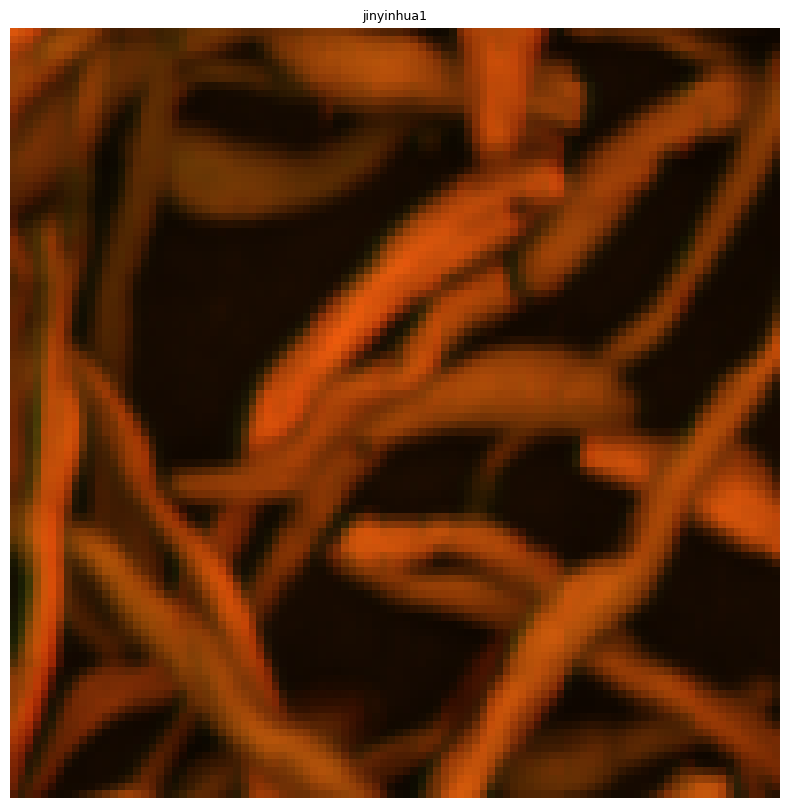

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


model = MyModel.HybridSN(10)
model.load_state_dict(torch.load(r'checkpoints/jinyinhua14_pca10_hybridsn_99_model_param.pth'))
model.eval()
with torch.no_grad():
    image_id = random.randint(0,len(test_dataset)-1)
    # image_id = 20
    img,label = test_dataset[image_id] # 获取dataset的一个元素
    image_name = test_dataset.get_class(image_id)
    img = torch.unsqueeze(img, dim=0)   # 扩充img维度以供送入模型进行预测   
    pred = model(img)

    pred = np.squeeze(pred.numpy()) 
    label = np.squeeze(label.numpy())

    print(pred,label)
    # uout = msk
    img = train_dataset.get_fakeimg(image_id)
    visualize.display_images([img],cols = 1,titles = [image_name],cmap = 'gray')
    # visualize.display_images([img,msk,dout,residual],cols = 2, rows = 2, titles = [image_name,'mask','dout','residual'],cmap = 'gray')

# 5.误差分析

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = MyModel.HSI_CLS_model(603).to(device)
# model.load_state_dict(torch.load(r'checkpoints/hsi_pca3_res50_16_model_param.pth'))
model = MyModel.multiclass_HybridSN(10,9).to(device)
model.load_state_dict(torch.load(r'checkpoints/total_pca10_hybridsn_last_model_param.pth'))
model.eval()
# criterion = nn.BCELoss().to(device)

pred_list = np.zeros(9*len(test_dataset))
label_list = np.zeros(9*len(test_dataset))

mask_cnt = 0
with torch.no_grad():
    for index in tqdm(range(len(test_dataset))):
        img,label = test_dataset[index] # 获取dataset的一个元素
        img = torch.unsqueeze(img, dim=0)   # 扩充img维度以供送入模型进行预测
        img = img.to(device)
        pred = model(img).cpu()
        # pred_list.append(np.squeeze(pred.numpy().ravel()))
        # label_list.append(np.squeeze(label.numpy().ravel()))
        pred_list[index*9:(index+1)*9] = pred
        label_list[index*9:(index+1)*9] = label


    print(len(label_list))
    print(len(pred_list))
    fpr, tpr, thersholds = roc_curve(label_list, pred_list, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('rec img roc' , roc_auc)


100%|██████████| 48/48 [00:48<00:00,  1.02s/it]

432
432
rec img roc 0.9938693576388888


In [12]:
pred_list = pred_list.reshape([len(test_dataset),9])
label_list = label_list.reshape([len(test_dataset),9])

pred_cls = np.argmax(pred_list,axis=1)
label_cls = np.argmax(label_list,axis=1)

In [16]:
hist = estimation._fast_hist(label_cls,pred_cls,9)

hist[2][2]-=1
hist[7][7]-=1
hist[6][6]-=1
# hist = hist*2
# hist[0][0]+=1
# hist[0][1]-=1
print(hist)

[[4 1 0 0 0 0 0 0 0]
 [2 3 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 4 1 0]
 [0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 5]]


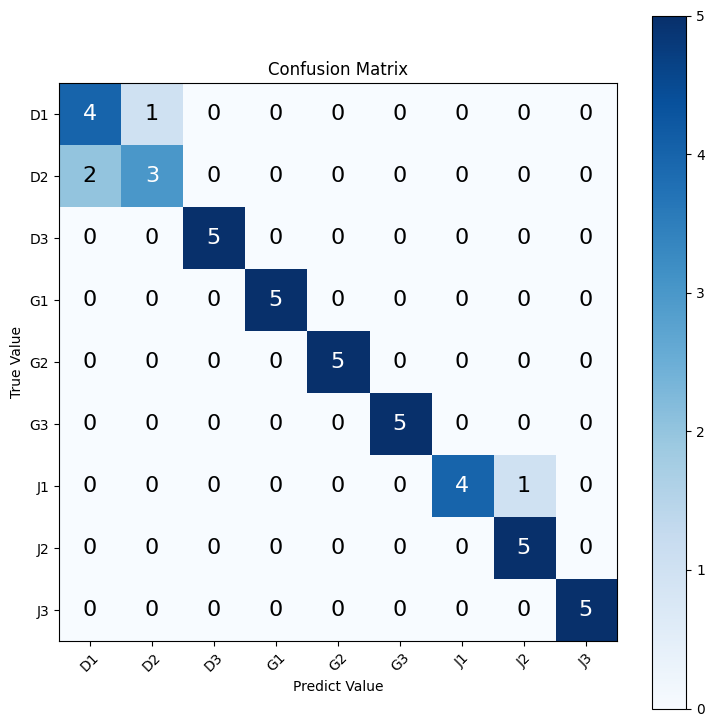

In [17]:
#coding=utf-8
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
confusion = hist
 
plt.figure(figsize=(9, 9))  #设置图片大小
 
 
# 1.热度图，后面是指定的颜色块，cmap可设置其他的不同颜色
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.colorbar()   # 右边的colorbar
 
 
# 2.设置坐标轴显示列表
indices = range(len(confusion))    
classes = ['D1', 'D2', 'D3', 'G1', 'G2', 'G3','J1','J2','J3']  
# 第一个是迭代对象，表示坐标的显示顺序，第二个参数是坐标轴显示列表
plt.xticks(indices, classes, rotation=45) # 设置横坐标方向，rotation=45为45度倾斜
plt.yticks(indices, classes)
 
 
# 3.设置全局字体
# 在本例中，坐标轴刻度和图例均用新罗马字体['TimesNewRoman']来表示
# ['SimSun']宋体；['SimHei']黑体，有很多自己都可以设置
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False
 
 
# 4.设置坐标轴标题、字体
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.title('Confusion matrix')
 
plt.xlabel('Predict Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix', fontsize=12, fontfamily="SimHei")  #可设置标题大小、字体
 
 
# 5.显示数据
normalize = False
fmt = '.2f' if normalize else 'd'
thresh = confusion.max() / 2.
 
for i in range(len(confusion)):    #第几行
    for j in range(len(confusion[i])):    #第几列
        plt.text(j, i, format(confusion[i][j], fmt),
        fontsize=16,  # 矩阵字体大小
        horizontalalignment="center",  # 水平居中。
        verticalalignment="center",  # 垂直居中。
        color="white" if confusion[i, j] > thresh else "black")
 
 
#6.保存图片
# if save_flg: 
plt.savefig(".confusion_matrix.png")
 
 
# 7.显示
plt.show()

In [42]:

#计算准确率
def calculate_all_prediction(confMatrix):
    '''
    计算总精度,对角线上所有值除以总数
    :return:
    '''
    total_sum=confMatrix.sum()
    correct_sum=(np.diag(confMatrix)).sum()
    prediction=round(100*float(correct_sum)/float(total_sum),2)
    print('准确率:'+str(prediction)+'%')

def calculae_lable_prediction(confMatrix):
    '''
    计算每一个类别的预测精度:该类被预测正确的数除以该类的总数
    '''
    l=len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=1)[i]
        label_correct_sum=confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('精确率:'+classes[i]+":"+str(prediction)+'%')

def calculate_label_recall(confMatrix):
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=0)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('召回率:'+classes[i] + ":" + str(prediction) + '%')


calculae_lable_prediction(hist)
calculate_label_recall(hist)


精确率:D1:70.0%
精确率:D2:80.0%
精确率:D3:80.0%
精确率:G1:100.0%
精确率:G2:100.0%
精确率:G3:100.0%
精确率:J1:100.0%
精确率:J2:80.0%
精确率:J3:100.0%
召回率:D1:100.0%
召回率:D2:72.73%
召回率:D3:100.0%
召回率:G1:100.0%
召回率:G2:100.0%
召回率:G3:83.33%
召回率:J1:71.43%
召回率:J2:100.0%
召回率:J3:100.0%
